In [1]:
library(tidyverse)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


# Lab 6. Diagnostic Tests
---

## Using R to produce ROC curves
---

Most of the material in this section follows the methods suggested in
https://publicifsv.sund.ku.dk/~tag/Teaching/share/R-tutorials/Advanced-statistics/How-to-Roc.html
and
https://cran.r-project.org/web/packages/plotROC/vignettes/examples.html

Install and upload the package `ModelGood`



In [2]:
install.packages("devtools")
require(devtools)


The downloaded binary packages are in
	/var/folders/3m/hvvbkscs3g18gqtdpjbjc7l80000gn/T//RtmprdWhTs/downloaded_packages


Loading required package: devtools

Loading required package: usethis



In [3]:
install_version("ModelGood", version = "1.0.8", repos = "http://cran.r-project.org/")
# install.packages("ModelGood")

ERROR: Error: Failed to install 'unknown package' from URL:
  Could not find tools necessary to compile a package
Call `pkgbuild::check_build_tools(debug = TRUE)` to diagnose the problem.


In [ ]:
library(ModelGood)

ERROR: Error in library(ModelGood): there is no package called ‘ModelGood’


Upload the SPSS data file “bTG data - diagnostic testing.sav” into R-Colab and define Diabetic as factor. You can change the factor levels to YES and NO.

In [ ]:
# Upload "bTG data - diagnostic testing.sav" into R-Colab
library(haven)
bTG_data <- read_sav("bTG data - diagnostic testing.sav")

In [ ]:
# Visualise the data (first six rows)
bTG_data

Define Diabetic as factor. You can change the factor levels to YES and NO.

In [ ]:
bTG_data$Diabetic <- as.factor(bTG_data$Diabetic)

In [ ]:
# Change the factor levels to YES and NO
levels(bTG_data$Diabetic)[1]<-"YES"
levels(bTG_data$Diabetic)[2]<-"NO"

To build the contingency table as in page 134 of the lecture notes we will create a new column in the datafile called “Diagnosed” with 20 as cut-off value:

In [ ]:
bTG_data$Diagnosed <- factor(bTG_data$bTG>20,levels=c(TRUE,FALSE),labels=c("Diabetic","normal")) 

In [ ]:
# Create and visualise the table Diagnosed vs Diseased (Diabetic)
with(bTG_data,table(exposure=Diagnosed,disease=Diabetic))

In [ ]:
with(bTG_data,Sensitivity(Diagnosed,Diabetic)) 

In [ ]:
levels(bTG_data$Diabetic)

In [ ]:
bTG_data$Diabetic <- relevel(bTG_data$Diabetic, "NO")

In [ ]:
?Sensitivity

We can now calculate sensitivity, specificity, NPV (negative predictive value) and PPV (positive predictive value). 

See https://www.rdocumentation.org/packages/epiR/versions/0.9-99/topics/epi.tests for a different method

In [ ]:
#Sensitivity
with(bTG_data,Sensitivity(Diagnosed,Disease)) 
#Specificity
with(bTG_data,Specificity(Diagnosed,Disease)) 
#NPV
with(bTG_data,NPV(Diagnosed,Disease)) 
#PPV
with(bTG_data,PPV(Diagnosed,Disease))

We can obtain the same result as follows:



In [ ]:
#Sensitivity
with(bTG_data,Sensitivity(bTG,Disease,cutoff=20,comparison=">")) 
#Specificity
with(bTG_data,Specificity(bTG,Disease,cutoff=20,comparison=">")) 
#NPV
with(bTG_data,NPV(bTG,Disease,cutoff=20,comparison=">")) 
#PPV
with(bTG_data,PPV(bTG,Disease,cutoff=20,comparison=">"))

In this way we are indicating that larger values imply disease. When the opposite is true you’ll need to use `comparison=“<”`.

We can now plot the ROC curves

In [ ]:
# Define the ROC curve
r.ROC <- Roc(Disease~bTG,data=bTG_data) 

#Plot the ROC curve
plot(r.ROC,auc=TRUE)

## Another method to build and visualise ROC curves

Install the package

In [ ]:
install.packages("plotROC")

and upload the library



In [ ]:
library(plotROC)
library(ggplot2)

To be able to use the ggplot to produce ROC curves, we need to define "Disease" as factor:

In [ ]:
bTG_data$Disease

In [ ]:
bTG_data$Diseasef <- as_factor(bTG_data$Disease)

In [ ]:
bTG_data$Diseasef

You can now plot the ROC curve with the following command


In [ ]:
basicplot <- ggplot(bTG_data, aes(d = Diseasef, m = bTG)) + geom_roc()
basicplot

If you want you can reduce the number of cut points visualised on the plot as follows

In [ ]:
ggplot(bTG_data, aes(d = Diseasef, m = bTG)) + geom_roc(n.cuts = 5, labelsize = 5, labelround = 2)

You can improve the plot as follows:

In [ ]:
styledplot <- basicplot + style_roc()
styledplot

or add extra information to the plot as follows

In [ ]:
basicplot +
style_roc(theme = theme_grey) +
theme(axis.text = element_text(size=15,colour = "blue"),
        axis.title=element_text(size=20,face="bold"),text=element_text(size=20)) +
ggtitle("Themes and annotations") + 
annotate("text", x = .75, y = .25, label = paste("AUC =", round(calc_auc(basicplot)$AUC, 2)),size=10) +
scale_x_continuous("1 - Specificity", breaks = seq(0, 1, by = .1))

*Other methods can be used to **estimate** the ROC curve. The important thing is that the cutoff, the TPF (true positive fraction) and the FPF (false positive fraction)
are calculated. Then you can use these values as arguments to the ggroc function, and overriding the default stat to `identity`.* (from: https://cran.r-project.org/web/packages/plotROC/vignettes/examples.html)

In [ ]:
# First let's relable Disease and bTG with lables easier to remember
D.ex <- bTG_data$Disease
M.ex <- bTG_data$bTG

# Now let's calculate (and save) the mean of bTG values for people with and without disease
mu1 <- mean(M.ex[D.ex == 1])
mu0 <- mean(M.ex[D.ex == 0])

# Now we do the same for the standard deviations
s1 <- sd(M.ex[D.ex == 1])
s0 <- sd(M.ex[D.ex == 0])

# Here we generate 300 random numbers between in the range (min(M.ex), max(M.ex))
c.ex <- seq(min(M.ex), max(M.ex), length.out = 300)

# Here we define the data frame with c.ex, FPF defined as the absolute value of 
# (mu0 - c.ex)/s0 and TPF as the absolute value of (mu1 - c.ex)/s1
binorm.roc <- data.frame(c = c.ex,
FPF = pnorm((mu0 - c.ex)/s0),
TPF = pnorm((mu1 - c.ex)/s1)
)

#The FPF and TPF can now be plotted and the approximation of the ROC curve visualised
binorm.plot <- ggplot(binorm.roc, aes(x = FPF, y = TPF, label = c)) +
geom_roc(stat = "identity") + style_roc(theme = theme_grey)

binorm.plot

## Likelihood Ratios & Nomograms

Likelihood Ratios provide a measure of the effect a test result has on the probability of disease.
The likelihood ratio is calculated by dividing the probability of a particular test result in a diseased person by the probability of the same test result in a person without disease.

> **Likelihood Ratio** = p(test result **given** disease present) / p(test result **given** disease absent)

In the simple case where a test is either positive or negative the Likelihood Ratio can be computed in terms of the sensitivity and specificity as follows:

> **(Positive) Likelihood Ratio** = p(+ve result | disease) / p(+ve result | no disease)

> **(Positive) Likelihood Ratio** = Sensitivity / (1 – Specificity)

Consider the first example from last week’s notes (Serum levels):

|    Test result?      | Diseased |Disease free|Total|
|----------------------|----------|------------|-----|
|**+VE** = Marker > 100|a = 431| b = 30|461|
|**−VE** = Marker < 100|c = 29 |d = 116|145|
|         Total        |  460  | 146   |606|

For these data we have: Sensitivity = 0.937 & Specificity = 0.795

$\implies$ **LR** = 0.937 / (1 − 0.795) = **4.56**

In this example a person with disease is 4.56 times more likely to test positive than a person without disease.

If a test produces a number of categorical results, then Likelihood ratios can be produced for each category (see the article by Deeks & Altman on Moodle).

Charts (called **Nomograms**) enable us to convert the pre-test probability of disease (prevalence) into a post-test probability of disease.

In R it is possible to calculate thepost test probability by using the `rms` package and its functions `nomogram` and `Predict` as explained below.

Try to understand how to use the `rms` package on the page: https://www.r-bloggers.com/2017/04/generating-dynamic-nomograms-using-dynnom/ 

In [ ]:
install.packages("rms")
library(rms)

Please notice that the Monogram we are going to make with rms is difefrent from the rappresnetation we have seen during the lecture.However, the final result and type of information we are going to get from it is the same, i.e. post-test probablilities of having the disease (in our case).

The first step is to create a logistic model that links the probability of diasese to the value of the factor/s measured during the test. Notice that we don't use the `glm` command, but the `lrm` contained in the package `rms`.

In [ ]:
fit <- lrm(formula = Disease ~ bTG, data = bTG_data)
fit

To make a nomogram we need to use the `datadist` function:

In [ ]:
ddist <- datadist(bTG_data)
options(datadist='ddist')

We are now ready for the nomogram:

In [ ]:
nom <- nomogram(fit, fun=plogis, funlabel="Risk of Disease")
plot(nom)

In order to use it we need to select the bTG value we are intreested in (or that we measured) and get the associated Points directly above it. In this case these will be the total amount of points. However, if we have more than one factor, we must add all points we get and this will give us the total amount of points. The total points is then used to get the associated probability (Risk of Disease) straight down from the linear predictor. For example:

    bTG=22 (35 points = total points)

35 Total Points lines up a little more than 0. So a person with a bTG value of 22 has about 50% risk of having the disease.

We can check our calculations, using the command `Predict`:

In [ ]:
Predict(fit, bTG=22, fun=plogis)

### Example

Nomogram for Diagnostic Testing

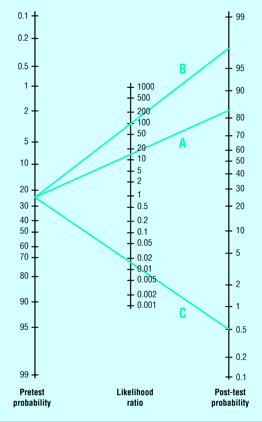

Suppose the prevalence of disease (pre-test probability) in a study population is 25% and the diagnostic test has a likelihood ratio of 15. If a subject produces a positive result on this diagnostic test then the revised (post-test) probability of disease is approximately 83% (See A on the chart above). 

## Use of the logistic regression for diagnostic test (optional)

In the procedures above we have focused on coding the results of a test as “positive” or “negative”. With a
continuous predictor variable X, the probability of disease might be predicted from X using Logistic regression.

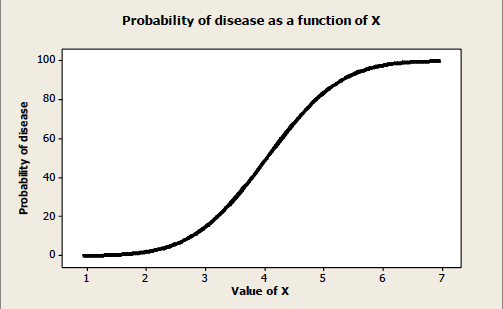

$$
P = \dfrac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}
$$

  The “logit” transformation gives: 
$$
    \log \dfrac{P}{1 – P} = \log (Odds) \beta_0 + \beta_1 X
$$

For the Urinary bTG data above it can be shown that we get: $\log(Odds) = − 1.887 + 0.088*bTG$

Using the command:

In [ ]:
lrm.bTG <- glm(Disease~bTG,data=bTG_data,family=binomial)

Predicting Ln(Odds) from X we get the Odds and hence risk of disease for different values of X using
$$
p = Odds/(1 + Odds).
$$

In [ ]:
#Don’t get confused with the Odds Ratio (= exp($\beta_1$)) that in R is calculated as follows
exp(coef(lrm.bTG))
exp(confint(lrm.bTG))

#You can plot the logistic curve using
plot(bTG_data$bTG, bTG_data$Disease)
curve(predict(lrm.bTG, data.frame(bTG=x), type="response"), add=TRUE)

Given values of X we can use the model to “classify” individuals according to the predicted probability.

> E.g. If **predicted probability > 0.5** $\implies$ **classify as positive** = diseased.

The predicted probabilities can be used to predict outcome, a probability of 0.5 or greater indicating that disease is more likely than not. We can build a classification table as follows (we have seen this during the logistic regression R session):

In [ ]:
#classification table: predicted probabilities 
Pprob <- fitted(lrm.bTG) 

# choose a threshold for dichotomizing according to predicted probability 
thresh <- 0.5 
PprobFac <- cut(Pprob, breaks=c(-Inf, thresh, Inf), labels=c("No", "Yes")) 

# contingency table and marginal sums 
cTab <- table(bTG_data$Disease, PprobFac) 
addmargins(cTab) 

#Calculate the percentage of total correct predictions 
print('The percentage of total corrected predictions is (x100)') 
sum(diag(cTab)) / sum(cTab)

Using a “cut-point” of 0.5 for the probability, the accuracy of using bTG is 68.4%.

In the lecture notes, from page 141
is shown how
ROC curves can be constructed using the predicted probabilities obtained with the logistic regression (in SPSS), treating them as a numeric test variable having values between 0 and 1.0.

When we have a single numeric predictor the ROC curve will be **IDENTICAL** to that derived from the original raw data. To obtain the ROC curve you’ll need to use the command

In [ ]:
roc.bTG <- Roc(lrm.bTG,data=bTG_data) 
plot(roc.bTG) 
print(roc.bTG)

### Exercises

#### Exercise 1

The table below shows the results of an HIV antibody assay among patients with AIDS and healthy blood donors (without AIDS). The results are expressed as the ratio of the mean absorbance of a pair of test samples divided by the mean absorbance of eight negative control wells.

|Ratio|Patients with AIDS|Healthy blood donors|Total|
|--------|-------------|--------------|----------------|
|12.0 +| 21|0|21|
|6.0 – (12.0)| 36|2|38|
|5.0 – (6.0)| 15|2|17|
|4.0 – (5.0)| 7|3|10|
|3.0 – (4.0)| 7|15|22|
|2.0 – (3.0)| 2|73|75|
|< (2.0)| 0|202|202|
|Total| 88 |297|385|

(Source: Weiss et al, 1985, Journal of the American Medical Association)

Using a cut-off value (ratio) of **3 or more** to define a “positive” test, determine the corresponding test sensitivity and specificity.


Complete the following table and sketch the ROC curve.

|Cut-off|Sensitivity %|Specificity %|
|-------|-------------|-------------|
|  12+  |     23.9    |    100.0    |
|   6+  |     64.8    |     99.3    |
|   5+  |     81.9    |     98.7    |
|   4+  |     89.8    |     97.6    |
|   3+  |||
|   2+  |    100.0    |     68.0    |

Suggest a suitable cut – point that optimises both sensitivity and specificity and compute the corresponding positive and negative predictive values for this group of individuals based upon this.

Determine the positive predictive value and negative predictive value of a test based upon your chosen cut – point when used in a population in which the prevalence of AIDS is 15%.

#### Exercise 2

Blood samples taken from a number of patients with (D) and without (H) a particular disease were analysed and the following data recorded: 

D 23 34 36 41 43 44 44 45 46 53 53 55 59 61 62 62 63 63 64 65 

H 23 28 29 31 32 33 35 36 37 37 37 37 38 38 41 41 44 46 52 58

* Using cut-points of, 30, 40 & 50 produce an ROC curve for these data. 
* What are the PPV and NPV for a cut-point of 40? 
* Use SPSS to fit a logistic regression model to these data. 
* Use the fitted model to predict the risk of disease in a patient with a measurement X = 55.




#### Exercise 3

This exercises requires the use of the file “SPSS Logistic regression 2 – MDM data”
Duchenne Muscular Dystrophy, DMD, is a genetically transmitted disease, passed from a mother to her children. Affected female offspring usually suffer no apparent symptoms and may unknowingly carry the disease. Male offspring with the disease die at a young age. A detection problem occurs when, for example, a woman suspects that she may be a carrier, possibly as a result of and affected male child in her extended family. Although carriers of DMD have no physical symptoms, they tend to exhibit elevated levels of certain serum enzymes or proteins, such as creatine kinase (CK), hemopexin (H), lactate dehydroginase (LD) and pyruvate kinase (PK). The first two serum markers (CK and H) may be measured relatively inexpensively from frozen serum. The second two (PK and LD) require fresh serum. The levels of these enzymes may also depend upon age.

The data file contains information for 82 women of whom 35 are known carriers of DMD.

Note that for some of the variables data is missing.

* Begin by producing an ROC curve for each of the possible predictors of disease. Which seems to be the best single discriminator of disease? {Note, enter all four variables to produce a single plot}
* Fit a logistic regression model predicting MDM from CK (Creatine Kinase) **alone** and save the predicted probabilities to the worksheet. Use the fitted model to calculate the p(MDM) for a subject with CK = 35. Plot an ROC curve using the predicted probabilities as the test variable and compare this to the ROC curve using actual CK measurements.
* Fit a logistic regression model predicting MDM from all four predictors and save the predicted probabilities from this model to the spreadsheet.
* Produce an ROC curve using CK, LD, H, PK and the predicted values from the logistic model using all four predictors. What does this plot show?

Carry out the Logrank test to determine if these two types of brain tumour lead to significantly different survival patterns? What do you conclude?

## Briefly on clinical trial

There is an online project where researchers are gathering together all R packages referring to the statistical study of clinical trials from the experimental design to the more general analysis of the data. Here is the link to the project:

https://cran.r-project.org/web/views/ClinicalTrials.html

Regarding our module there are only two tests that we will learn how to use in R: **the t-test and the MannWhitney Sum of Ranks test**.

### 2-sample t-test

**Test group =** 1: 11.8 8.4 9.9 15.6 2.1 35.2 4.3 5.8 6.9 26.3

**Control Group =** 2: 6.5 35.7 8.4 28.9 46.3 58.7 10.0 11.1 12.8 19.0

Enter the data in R. You can choose your favourite method. If you define two vectors you can run the t test using the command `t.test`.

In [ ]:
y1<-c(11.8, 8.4, 9.9, 15.6, 2.1, 35.2, 4.3, 5.8, 6.9, 26.3) 
y2<-c(6.5, 35.7, 8.4, 28.9, 46.3, 58.7, 10.0, 11.1, 12.8, 19.0)

In [ ]:
# independent 2-group t-test 
t.test(y1,y2) # where y1 and y2 are numeric

**What does the test tell you? And what can you say about the means of the test and control group?**

The command `t.test` does not assume that the variances of the groups are equal. If you want to assume that you’ll need to use a Levene’s test. Look at the following page to understand how to use this test:

http://www.sthda.com/english/wiki/compare-multiple-sample-variances-in-r#compute-levenes-test-in-r

If you defined the treatments as separate vectors you’ll need to create a pooled vector with the two you have, and a group variable, as follows:

In [ ]:
install.packages("car")
library(car)

In [ ]:
y <- c(y1, y2) 
group <- as.factor(c(rep(1, length(y1)), rep(2, length(y2))))

In [ ]:
# Levene's test with one independent variable
leveneTest(y,group)

### Mann Whitney Sum of Ranks test

Nonparametric test to compare two groups of data that are not normally distributed. By default, the Wilcoxon rank test in R runs with continuity correction. For this reason, we will set correct=FALSE

In [ ]:
wilcox.test(y1,y2,correct=FALSE)

To learn about the mean and sum of ranks we need to use the following functions:

In [ ]:
# Sum of ranks and mean for the test group
sum(rank(c(y1,y2))[1:10]) 
mean(rank(c(y1,y2))[1:10])

Calculates the same quantities for the control group. Given the test result what do you conclude?